In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso  # Import Ridge and Lasso
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV for hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score  # Import metrics for evaluation


**Exploratory Data Analysis**

*******Training HEAD*******
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SaleP

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


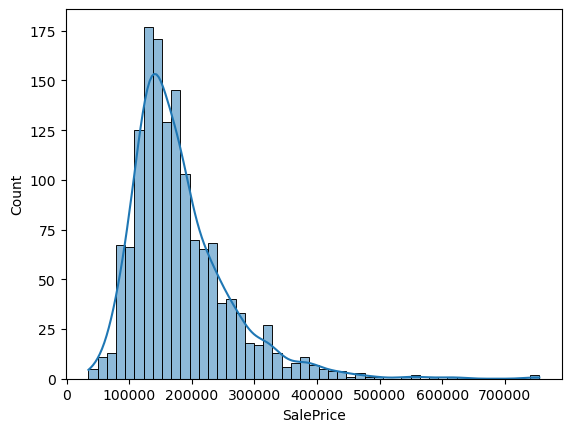

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


# Check the data
print('*******Training HEAD*******')
print(train.head())
print('*******Training INFO*******')
print(train.info())
print('*******Training Describe*******')
print(train.describe())



# Visualize the target variable (SalePrice)
sns.histplot(train['SalePrice'], kde=True)
plt.show()

# Check correlations
# Select only the numeric columns
numeric_columns = train.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation = numeric_columns.corr()



**Finding Correlation**

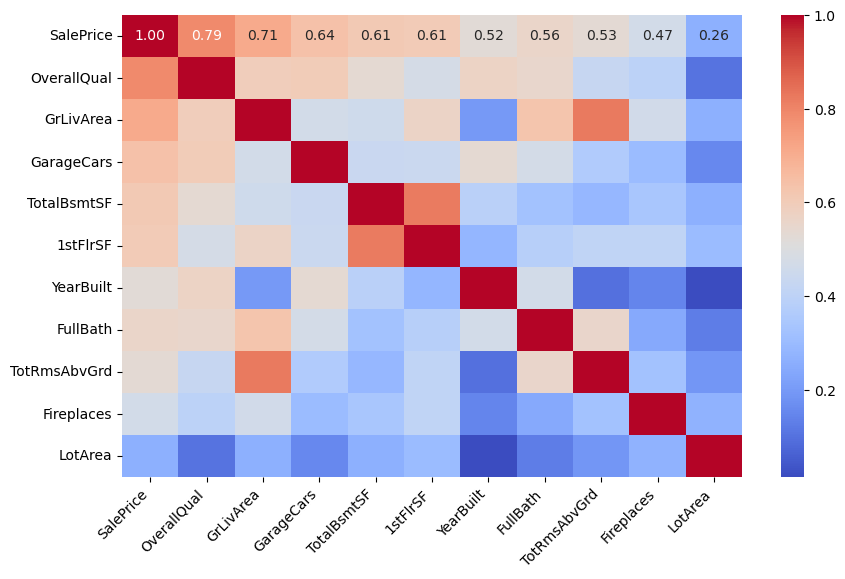

In [4]:
# Since we have lots of variables, we are only cosidering variables that matter the most to Sales Price of a house
# Select an extended subset of important numeric columns
extended_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 
                     '1stFlrSF', 'YearBuilt', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'LotArea']

# Create a new correlation matrix with only the selected key features
extended_corr = train[extended_features].corr()

# Increase figure size to make the heatmap clearer
plt.figure(figsize=(10, 6))

# Plot the heatmap for key features
sns.heatmap(extended_corr, annot=True, cmap='coolwarm', fmt=".2f")

# Rotate the x and y labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()


In [7]:
# 1. Check for missing values before handling
missing_values = train.isnull().sum().sort_values(ascending=False)
print("Missing values before handling:", missing_values[missing_values > 0])

#  Fill missing values for numerical columns (LotFrontage is included in this step)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].mean())

# 3. Fill missing values for categorical columns with the mode
categorical_cols = train.select_dtypes(include=['object']).columns
train[categorical_cols] = train[categorical_cols].fillna(train[categorical_cols].mode().iloc[0])

# 4. Drop specific columns only if they exist in the DataFrame
columns_to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train.drop(columns=[col for col in columns_to_drop if col in train.columns], inplace=True)

# 5. Verify if any missing values remain
missing_values_after = train.isnull().sum().sum()
print(f"Remaining missing values after filling: {missing_values_after}")

Missing values before handling: MasVnrType      872
FireplaceQu     690
GarageCond       81
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
Electrical        1
dtype: int64
Remaining missing values after filling: 0


In [8]:
# Log Transformation of the Target Variable ('SalePrice')

# Apply log transformation to 'SalePrice' to reduce skewness
train['SalePrice'] = np.log1p(train['SalePrice'])  # log(1 + SalePrice) for numerical stability

In [30]:
# Encoding Categorical Variables

# Convert categorical variables to dummy/indicator variables
train = pd.get_dummies(train)


In [10]:
#  Scaling Numerical Features

# Scaling selected numerical features ('GrLivArea', 'TotalBsmtSF') to standardize them
numerical_features = ['GrLivArea', 'TotalBsmtSF']
scaler = StandardScaler()
train[numerical_features] = scaler.fit_transform(train[numerical_features])

In [11]:
#  Splitting Data for Training and Validation

# Separate the target variable (log-transformed 'SalePrice') from the features
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#  Linear Regression Model

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation data
y_pred_log = lr_model.predict(X_val)

# Reverse the log transformation of predictions and actual values
y_pred = np.expm1(y_pred_log)  # expm1(x) = exp(x) - 1
y_val_original = np.expm1(y_val)  # Reverse log transformation of actual values

# Evaluate Linear Regression model
lr_rmse = mean_squared_error(y_val_original, y_pred, squared=False)
lr_r2 = r2_score(y_val_original, y_pred)

print('Linear Regression RMSE:', lr_rmse)
print('Linear Regression R^2:', lr_r2)

Linear Regression RMSE: 22918.05135080891
Linear Regression R^2: 0.9315235019305744


In [27]:
#  Ridge Regression Model
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)
y_pred_ridge_log = ridge_model.predict(X_val)

# Calculate RMSE for Ridge Regression
rmse_ridge = mean_squared_error(y_val, y_pred_ridge_log, squared=False)
print('Ridge Regression RMSE (Log-transformed):', rmse_ridge)

# Calculate R-squared for Ridge Regression
r2_ridge = r2_score(y_val, y_pred_ridge_log)
print('Ridge Regression R^2:', r2_ridge)

Ridge Regression RMSE (Log-transformed): 0.12660828235398058
Ridge Regression R^2: 0.9141012151437288


In [14]:
# 11. Lasso Regression Model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
y_pred_lasso_log = lasso_model.predict(X_val)

# Calculate RMSE for Lasso Regression
rmse_lasso = mean_squared_error(y_val, y_pred_lasso_log, squared=False)
print('Lasso Regression RMSE (Log-transformed):', rmse_lasso)

# Calculate R-squared for Lasso Regression
r2_lasso = r2_score(y_val, y_pred_lasso_log)
print('Lasso Regression R^2:', r2_lasso)

Lasso Regression RMSE (Log-transformed): 0.18081942201724835
Lasso Regression R^2: 0.8247924003518537


Best Ridge Alpha: 13.89495494373136
Ridge Regression RMSE: 0.010661472042955276, R^2: 0.8969947503826204
Best Lasso Alpha: 0.0001
Lasso Regression RMSE: 0.01109025988345336, R^2: 0.8885427147848284


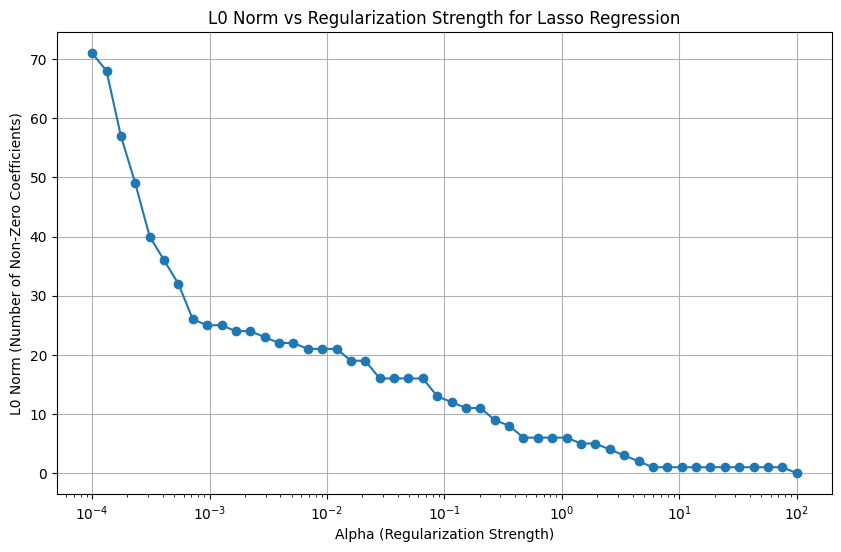

In [17]:


# Assuming the dataset is preprocessed and split into training and validation sets
# X_train, X_val, y_train_log, y_val_log contain the features and target (log-transformed SalePrice)

# Apply log transformation to SalePrice
y_train_log = np.log1p(y_train)  # Apply log1p to avoid log(0) errors
y_val_log = np.log1p(y_val)      # Do the same for validation set if needed

# 1. Ridge and Lasso Regression - Hyperparameter Tuning

# Define hyperparameter grid for Ridge and Lasso (values of regularization parameter alpha)
alphas = np.logspace(-4, 2, 50)  # Alpha range from 1e-4 to 1e2

# 2. Ridge Regression with Cross-Validation
ridge = Ridge(max_iter=10000)
ridge_cv = GridSearchCV(ridge, {'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train_log)
best_ridge = ridge_cv.best_estimator_
best_ridge_alpha = ridge_cv.best_params_['alpha']

# Evaluate on validation set
y_pred_ridge = best_ridge.predict(X_val)
ridge_rmse = np.sqrt(mean_squared_error(y_val_log, y_pred_ridge))
ridge_r2 = r2_score(y_val_log, y_pred_ridge)

# 3. Lasso Regression with Cross-Validation
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso, {'alpha': alphas}, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train_log)
best_lasso = lasso_cv.best_estimator_
best_lasso_alpha = lasso_cv.best_params_['alpha']

# Evaluate on validation set
y_pred_lasso = best_lasso.predict(X_val)
lasso_rmse = np.sqrt(mean_squared_error(y_val_log, y_pred_lasso))
lasso_r2 = r2_score(y_val_log, y_pred_lasso)

# 4. Results
print(f'Best Ridge Alpha: {best_ridge_alpha}')
print(f'Ridge Regression RMSE: {ridge_rmse}, R^2: {ridge_r2}')

print(f'Best Lasso Alpha: {best_lasso_alpha}')
print(f'Lasso Regression RMSE: {lasso_rmse}, R^2: {lasso_r2}')

# 5. L0 Norm (Number of non-zero coefficients) for Lasso
l0_norms = []
for alpha in alphas:
    lasso_temp = Lasso(alpha=alpha, max_iter=10000)
    lasso_temp.fit(X_train, y_train_log)
    l0_norms.append(np.sum(lasso_temp.coef_ != 0))  # Count non-zero coefficients

# Plot L0 Norm vs Alpha (Regularization strength)
plt.figure(figsize=(10, 6))
plt.plot(alphas, l0_norms, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('L0 Norm (Number of Non-Zero Coefficients)')
plt.title('L0 Norm vs Regularization Strength for Lasso Regression')
plt.grid(True)
plt.show()


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Assuming train is your DataFrame and 'SalePrice' is the target variable
X = train.drop(columns=['SalePrice'])  # Features
y = train['SalePrice']  # Target variable

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base models
model1 = RandomForestRegressor(n_estimators=100, random_state=42)
model2 = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit base models
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

# Generate predictions on the validation set
preds_model1 = model1.predict(X_val)
preds_model2 = model2.predict(X_val)

# Create a new dataset for the meta-model
X_meta = np.column_stack((preds_model1, preds_model2))

# Train Ridge regression on the combined dataset
ridge = Ridge(alpha=1.0)  # Adjust the alpha for regularization
ridge.fit(X_meta, y_val)

# Generate predictions from the Ridge regression model
preds_ridge = ridge.predict(X_meta)

# Evaluate the performance of the Ridge regression model
mse_ridge = mean_squared_error(y_val, preds_ridge)
print(f'Ridge Regression Mean Squared Error: {mse_ridge:.2f}')

# You can also check the score using cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, val_index in kf.split(X):
    X_train_kf, X_val_kf = X.iloc[train_index], X.iloc[val_index]
    y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[val_index]
    
    # Fit base models
    model1.fit(X_train_kf, y_train_kf)
    model2.fit(X_train_kf, y_train_kf)

    # Generate predictions
    preds_model1_kf = model1.predict(X_val_kf)
    preds_model2_kf = model2.predict(X_val_kf)

    # Create a new dataset for the meta-model
    X_meta_kf = np.column_stack((preds_model1_kf, preds_model2_kf))

    # Train Ridge regression on the combined dataset
    ridge.fit(X_meta_kf, y_val_kf)

    # Evaluate performance
    preds_ridge_kf = ridge.predict(X_meta_kf)
    mse_ridge_kf = mean_squared_error(y_val_kf, preds_ridge_kf)
    scores.append(mse_ridge_kf)

print(f'Mean Cross-Validated MSE for Ridge Regression: {np.mean(scores):.2f}')


Ridge Regression Mean Squared Error: 0.02
Mean Cross-Validated MSE for Ridge Regression: 0.02


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_samples = 100
n_features = 20
true_support_size = 5
noise_level = 1.0

# Generate random features
X = np.random.randn(n_samples, n_features)

# Generate coefficients for true support
true_coefficients = np.zeros(n_features)
true_coefficients[:true_support_size] = np.random.randn(true_support_size)

# Generate target variable with added noise
y = X.dot(true_coefficients) + noise_level * np.random.randn(n_samples)

# Convert to DataFrame for easier manipulation
X = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(n_features)])


In [22]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def forward_selection(X, y):
    remaining_features = list(X.columns)
    selected_features = []
    current_score = float("inf")
    
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            model = Lasso(alpha=0.1)  # You can adjust alpha based on your preference
            model.fit(X[selected_features + [candidate]], y)
            y_pred = model.predict(X[selected_features + [candidate]])
            score = mean_squared_error(y, y_pred)
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_score, best_candidate = scores_with_candidates[0]
        
        if current_score - best_score < 1e-5:  # Stop if no significant improvement
            break
            
        current_score = best_score
        selected_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        
        print(f"Selected Feature: {best_candidate}, Score: {best_score}")
    
    return selected_features

selected_features = forward_selection(X, y)
print("Final selected features:", selected_features)


Selected Feature: Feature_4, Score: 1.6641897266702201
Selected Feature: Feature_2, Score: 1.0243962946409204
Selected Feature: Feature_0, Score: 0.8879077110903555
Selected Feature: Feature_7, Score: 0.8532537232806839
Selected Feature: Feature_8, Score: 0.824087905763409
Selected Feature: Feature_15, Score: 0.8024228828632478
Selected Feature: Feature_10, Score: 0.7863833024802221
Selected Feature: Feature_3, Score: 0.7851058104045988
Selected Feature: Feature_19, Score: 0.7847885559834954
Final selected features: ['Feature_4', 'Feature_2', 'Feature_0', 'Feature_7', 'Feature_8', 'Feature_15', 'Feature_10', 'Feature_3', 'Feature_19']


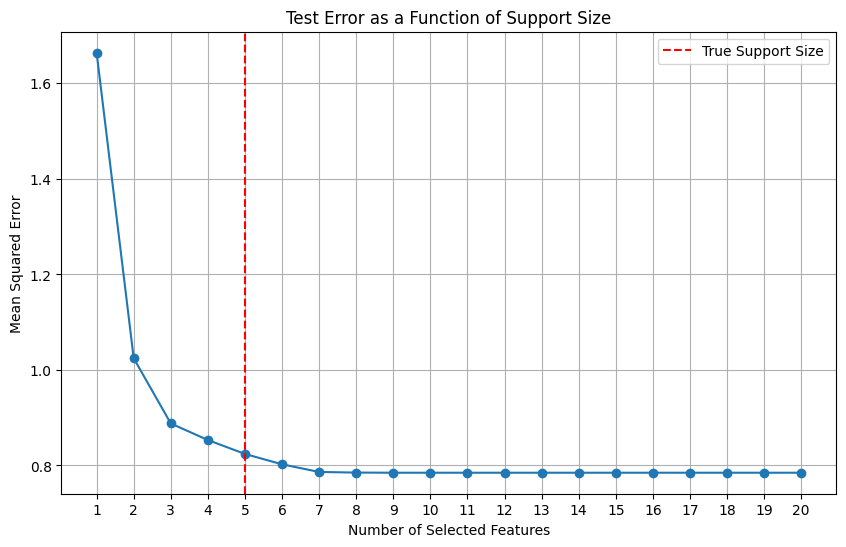

In [23]:
# Compute test error for varying support sizes
test_errors = []
support_sizes = list(range(1, n_features + 1))

for size in support_sizes:
    model = Lasso(alpha=0.1)  # Adjust alpha based on your preference
    model.fit(X[selected_features[:size]], y)
    y_pred = model.predict(X[selected_features[:size]])
    test_errors.append(mean_squared_error(y, y_pred))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(support_sizes, test_errors, marker='o')
plt.axvline(x=true_support_size, color='r', linestyle='--', label='True Support Size')
plt.title('Test Error as a Function of Support Size')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Squared Error')
plt.xticks(support_sizes)
plt.legend()
plt.grid()
plt.show()


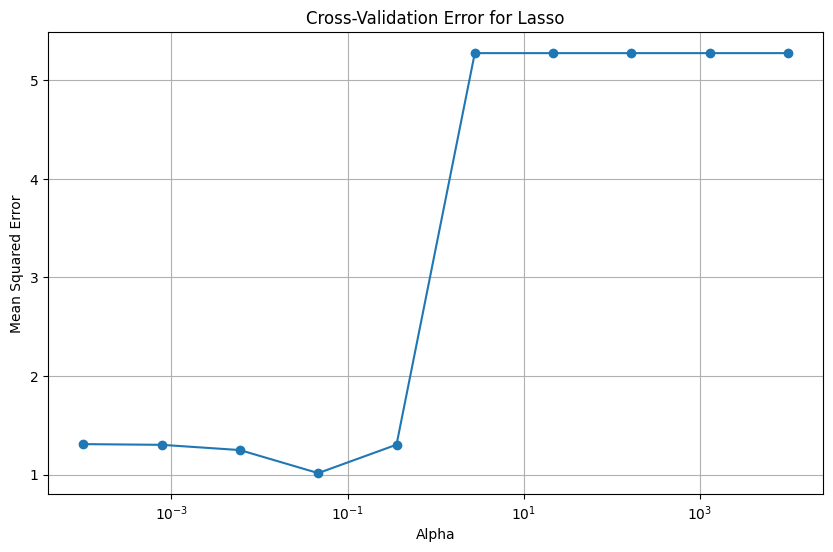

Optimal alpha value: 0.046415888336127774


In [24]:
from sklearn.model_selection import KFold

def manual_lasso_cv(X, y, alphas, n_splits=5):
    kf = KFold(n_splits=n_splits)
    cv_errors = []

    for alpha in alphas:
        fold_errors = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = Lasso(alpha=alpha)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            fold_errors.append(mean_squared_error(y_val, y_pred))

        cv_errors.append(np.mean(fold_errors))

    return cv_errors

# Define a range of alpha values for cross-validation
alphas = np.logspace(-4, 4, 10)
cv_errors = manual_lasso_cv(X, y, alphas)

# Plotting the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(alphas, cv_errors, marker='o')
plt.xscale('log')
plt.title('Cross-Validation Error for Lasso')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.grid()
plt.show()

# Find the optimal alpha
optimal_alpha = alphas[np.argmin(cv_errors)]
print(f"Optimal alpha value: {optimal_alpha}")


In [25]:
# Test with different number of folds
n_splits_list = [3, 5, 10]
optimal_alphas = []

for n_splits in n_splits_list:
    cv_errors = manual_lasso_cv(X, y, alphas, n_splits=n_splits)
    optimal_alpha = alphas[np.argmin(cv_errors)]
    optimal_alphas.append(optimal_alpha)
    print(f"Optimal alpha for {n_splits} folds: {optimal_alpha}")


Optimal alpha for 3 folds: 0.046415888336127774
Optimal alpha for 5 folds: 0.046415888336127774
Optimal alpha for 10 folds: 0.046415888336127774


In [26]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)
print(f"Optimal alpha using LassoCV: {lasso_cv.alpha_}")


Optimal alpha using LassoCV: 0.046415888336127774
